In [1]:
 import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [2]:
#Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [3]:
# Ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print("GPU is being used.")
else:
  print("GPU is not being used.")

GPU is being used.


In [4]:
# PAth to the dataset
dataset_path ="/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

#List all the classes (Animal types)
classes = os.listdir(dataset_path)
num_classes = len(classes)

#Display the nuber of classes along with names
print(f'Number of classes:', {num_classes})
print(f'Classes : {classes}')


Number of classes: {90}
Classes : ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']


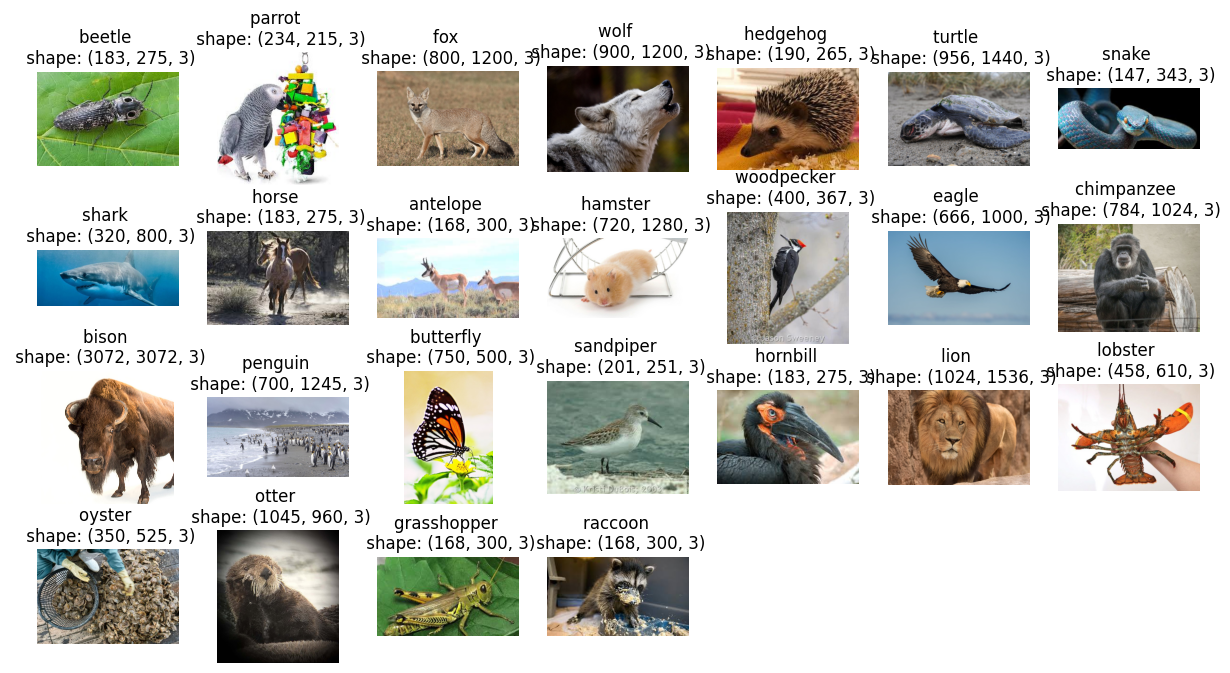

In [5]:
# Visualize some sample images form the dataset
import os
import matplotlib.pyplot as plt

# Assuming 'classes' is a list of class names and 'dataset_path' is the path to your dataset
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes[:25]):
    class_path = os.path.join(dataset_path, class_name)
    img_name = os.listdir(class_path)[0]  # Get the first image in the class directory
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)

    plt.subplot(5, 7, i + 1)  # Create a subplot for each image
    plt.imshow(img)
    plt.title(f'{class_name} \n shape: {img.shape}')
    plt.axis('off')  # Turn off axis

plt.show()  # Call show() with parentheses to display the plot

In [6]:
#preprocessing the data.
#Define image size and batch_size - Trained model - mobileNetV2 - 224 x 224
img_size=(224, 224)
batch_size=64 #There can be 64 images in a batch

#Data Augmentation and preprocessing
datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

#Create training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator=datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [7]:
# Map the classes - class_indices
class_indices = train_generator.class_indices
print(class_indices)
##Exttract class names
class_names = list(class_indices.keys())
print("Class Names",class_names)


{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [33]:
#Load MobileNetV2 as the base model
base_model = MobileNetV2(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3)
)

#Freeze the base model weights, training
base_model.trainable = False

#Add custon layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)#output layer

#Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

#Compile the model
model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

#Model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
# Train the model
histroy = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  validation_data=validation_generator,
  validation_steps=validation_generator.samples //batch_size,
  epochs=20,
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 537ms/step - accuracy: 0.3275 - loss: 3.1517 - val_accuracy: 0.7734 - val_loss: 0.8233
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7344 - loss: 1.1794 - val_accuracy: 0.7734 - val_loss: 0.8408
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 543ms/step - accuracy: 0.8163 - loss: 0.6560 - val_accuracy: 0.8125 - val_loss: 0.6303
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8281 - loss: 0.5382 - val_accuracy: 0.7969 - val_loss: 0.6834
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 546ms/step - accuracy: 0.8845 - loss: 0.3706 - val_accuracy: 0.8438 - val_loss: 0.5646
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8750 - loss: 0.4679 - val_accuracy: 0.8438 - val_loss: 0.5726
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 557ms/step - accuracy: 0.9278 - loss: 0.2426 - val_accuracy: 0.8457 - val_loss: 0.5116
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8906 - loss: 0.3165 - val_accuracy: 0.

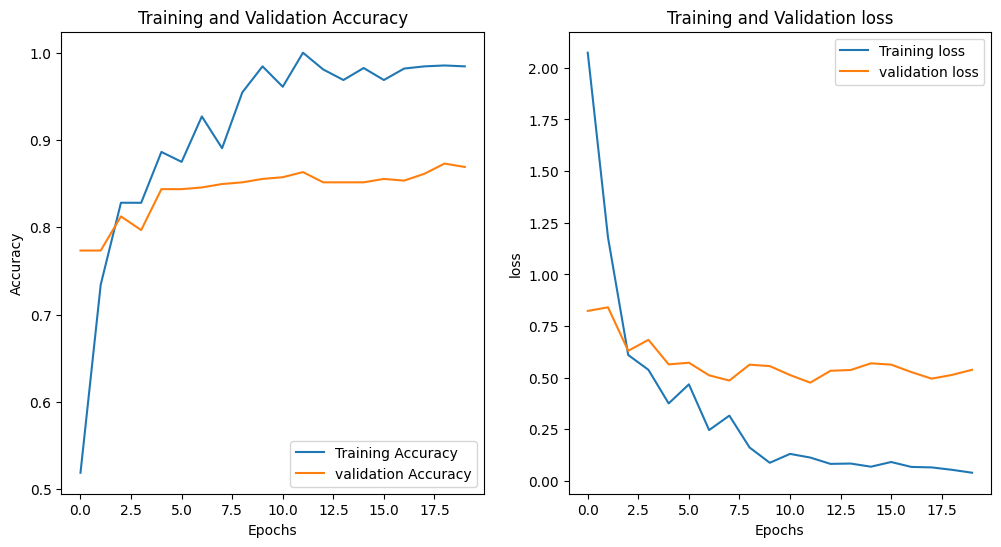

In [35]:
# Evalute the model - ploting the trainning and validation acc/loss
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(histroy.history['accuracy'],label='Training Accuracy')
plt.plot(histroy.history['val_accuracy'],label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(histroy.history['loss'],label='Training loss')
plt.plot(histroy.history['val_loss'],label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [36]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'VAlidation loss : {val_loss}')
print(f'Validation Accuracy : {val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step - accuracy: 0.8908 - loss: 0.4819
VAlidation loss : 0.5344087481498718
Validation Accuracy : 0.8722222447395325


In [37]:
#Save the model
model.save('MCAR.keras')

In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('MCAR.keras')

def predict_animal(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction = model.predict(img_array)
  predicted_class = class_names[np.argmax(prediction)]

  plt.imshow(img)
  plt.title(f"prediction: {predicted_class}")
  plt.axis('off')
  plt.show()

In [39]:
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/cat')

['4815f8dfaa.jpg',
 '4c6ff6dae0.jpg',
 '1f016e1910.jpg',
 '8d88a86d91.jpg',
 '0d0d6d90d8.jpg',
 '4bd8b7789f.jpg',
 '6edc079fcf.jpg',
 '6fe978c917.jpg',
 '8af49688fa.jpg',
 '124eecb74f.jpg',
 '34fb30ecc5.jpg',
 '730d6a8791.jpg',
 '578d493138.jpg',
 '9293137b5d.jpg',
 '612c521481.jpg',
 '11883c3dd8.jpg',
 '6a5e9eac29.jpg',
 '057e6db146.jpg',
 '00357563a7.jpg',
 '67dc417509.jpg',
 '1a2dce7848.jpg',
 '68a2e3af59.jpg',
 '2d7dc1ddb5.jpg',
 '8aefee4c2c.jpg',
 '0c3d04bcf5.jpg',
 '71c2375c64.jpg',
 '83e8a824a2.jpg',
 '354bb2acdf.jpg',
 '9fd544a838.jpg',
 '6128bd1a84.jpg',
 '31ae8d36b6.jpg',
 '15b23c04b7.jpg',
 '5a5cdbdc6b.jpg',
 '5e07a0666d.jpg',
 '094ac674a9.jpg',
 '98470f6918.jpg',
 '636b432421.jpg',
 '5aaea25f27.jpg',
 '2a40de8365.jpg',
 '78359cbe21.jpg',
 '3321ec48a8.jpg',
 '72c56919f9.jpg',
 '84db062d1f.jpg',
 '9d21019336.jpg',
 '087d293433.jpg',
 '77dee19720.jpg',
 '0b54dde5f5.jpg',
 '76273ddb00.jpg',
 '6296ca5ccf.jpg',
 '66548aefad.jpg',
 '39ae72da61.jpg',
 '32cd00f171.jpg',
 '9e020b77ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


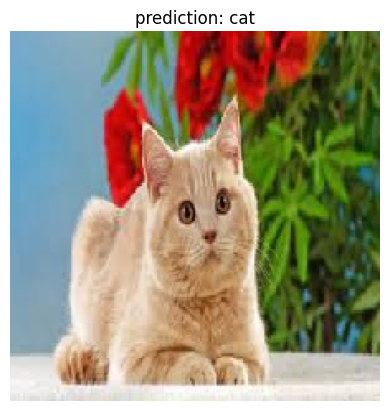

In [40]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/cat/68a2e3af59.jpg')